## Required libraries:

In [1]:
from google.colab import drive
import os
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', size=12)
plt.rc('figure', figsize = (12, 5))

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Attention
from tensorflow.keras.layers import *

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# sklearn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Load processed Data Frame of Bicing: 2019-2022**
All data processement can be checked on file:

[01_DF_creation_Station&Bicing_info](https://colab.research.google.com/drive/1L4QHje5e7tBrphzDqBJ0FZrVmALJmC0g?usp=sharing)


In [3]:
df = pd.read_csv('/content/drive/My Drive/CapstoneProject_NathyDani/df_final.csv')

In [4]:
df.shape

(2967415, 18)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2967415 entries, 0 to 2967414
Data columns (total 18 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   station_id                  int64  
 1   lat                         float64
 2   lon                         float64
 3   altitude                    float64
 4   address                     object 
 5   post_code                   int64  
 6   capacity                    int64  
 7   date                        object 
 8   year                        int64  
 9   month                       int64  
 10  day                         int64  
 11  day_of_week                 int64  
 12  hour                        int64  
 13  percentage_docks_available  float64
 14  ctx-4                       float64
 15  ctx-3                       float64
 16  ctx-2                       float64
 17  ctx-1                       float64
dtypes: float64(8), int64(8), object(2)
memory usage: 407.5+ MB


###Test for training the model only with data from 2021 and 2022:
After some test training, we decided to continue training the model only with data for the years 2021 and 2022.

In [6]:
df_21_22 = df.drop(df[(df['year'] == 2019) | (df['year'] == 2020)].index)

df_21_22['year'].unique()

array([2022, 2021])

In [7]:
df_21_22.shape

(1751108, 18)

###Test for training the model with weather data:

The notebook with weather data can be checked on file:

[05_Weather.ipynb](https://colab.research.google.com/drive/1y7tMZKz_pnfuIOPiiqTcbqdbHNBtGNey?usp=sharing)


In [8]:
weather = pd.read_csv('/content/drive/My Drive/CapstoneProject_NathyDani/df_weather.csv')

In [9]:
weather

,date,temp,prec,wind
0,2021-01-01,6.9,10.1,2.8
1,2021-01-02,6.2,0.0,4.2
2,2021-01-03,5.6,0.0,3.6
3,2021-01-04,5.9,0.0,3.6
4,2021-01-05,5.4,0.0,3.1
...,...,...,...,...
815,2023-03-27,15.0,0.0,3.9
816,2023-03-28,14.6,0.0,4.7
817,2023-03-29,14.7,0.0,8.3
818,2023-03-30,14.0,0.0,3.3


In [10]:
df_weather = pd.merge(df_21_22, weather, on='date', how='left')

In [11]:
df_weather.isnull().sum()

station_id                    0
lat                           0
lon                           0
altitude                      0
address                       0
post_code                     0
capacity                      0
date                          0
year                          0
month                         0
day                           0
day_of_week                   0
hour                          0
percentage_docks_available    0
ctx-4                         0
ctx-3                         0
ctx-2                         0
ctx-1                         0
temp                          0
prec                          0
wind                          0
dtype: int64

###Test for training the model with labels:

The notebook with the data of the stations divided into clusters can be checked on file:

[04_Clusters_stations.ipynb](https://colab.research.google.com/drive/1N2e-UfquKDUeBVqa54jmTxLwIGbNln70?usp=sharing)

In [12]:
labels = pd.read_csv('/content/drive/My Drive/CapstoneProject_NathyDani/df_labels.csv')

In [13]:
labels

,station_id,label
0,1,4
1,2,4
2,3,4
3,4,2
4,5,1
...,...,...
504,515,1
505,516,2
506,517,2
507,518,3


In [14]:
df_labels = pd.merge(df_weather, labels, on='station_id', how='left')

### Selecting the df:

In [15]:
df_model = df_labels.copy()

## Selecting columns:

In [16]:
corr_matrix = df_model.corr()
corr_matrix['percentage_docks_available'].sort_values(ascending=False)

<ipython-input-16-7ac441ddf6ee>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_model.corr()


percentage_docks_available    1.000000
ctx-1                         0.910030
ctx-2                         0.791951
ctx-3                         0.689114
ctx-4                         0.597569
altitude                      0.342513
lat                           0.140444
station_id                    0.138987
label                         0.047892
temp                          0.036678
hour                          0.031924
month                         0.018863
post_code                     0.016895
year                          0.002786
day                           0.001416
wind                         -0.000413
prec                         -0.006760
capacity                     -0.009374
day_of_week                  -0.012123
lon                          -0.237852
Name: percentage_docks_available, dtype: float64

In [17]:
corr_matrix.style.background_gradient(cmap='coolwarm')

,station_id,lat,lon,altitude,post_code,capacity,year,month,day,day_of_week,hour,percentage_docks_available,ctx-4,ctx-3,ctx-2,ctx-1,temp,prec,wind,label
station_id,1.000000,0.277881,-0.174827,0.414252,0.021220,-0.030654,0.001119,0.001039,-0.000062,0.000086,-0.000524,0.138987,0.139005,0.138859,0.139316,0.139304,0.000004,0.000265,-0.000198,0.069964
lat,0.277881,1.000000,0.423214,0.365018,0.127248,-0.103424,0.002015,0.001249,-0.000143,-0.000168,-0.000649,0.140444,0.140357,0.140437,0.140205,0.140282,-0.000097,0.000138,-0.000539,0.064165
lon,-0.174827,0.423214,1.000000,-0.564201,0.021630,0.062601,-0.000781,-0.000536,0.000088,-0.000322,0.000196,-0.237852,-0.237381,-0.237511,-0.237741,-0.238142,-0.000318,0.000042,0.000072,-0.201350
altitude,0.414252,0.365018,-0.564201,1.000000,0.081194,-0.102880,0.002138,0.001333,-0.000094,0.000060,-0.000733,0.342513,0.342035,0.342299,0.342037,0.342625,0.000030,0.000082,-0.000479,0.172442
post_code,0.021220,0.127248,0.021630,0.081194,1.000000,0.180624,0.000387,0.000462,0.000061,-0.000007,-0.000289,0.016895,0.016652,0.016543,0.016617,0.016849,-0.000003,0.000078,-0.000213,0.034347
capacity,-0.030654,-0.103424,0.062601,-0.102880,0.180624,1.000000,-0.001691,-0.001284,-0.000320,-0.000156,0.000044,-0.009374,-0.009641,-0.009916,-0.009528,-0.009211,-0.000560,-0.000100,0.000398,-0.055054
year,0.001119,0.002015,-0.000781,0.002138,0.000387,-0.001691,1.000000,0.001499,-0.000419,-0.000519,-0.000590,0.002786,0.002852,0.002880,0.002784,0.002709,0.099273,-0.011497,-0.037527,0.001181
month,0.001039,0.001249,-0.000536,0.001333,0.000462,-0.001284,0.001499,1.000000,0.014722,-0.006841,0.000099,0.018863,0.018828,0.019001,0.018793,0.019069,0.341860,0.064975,-0.133107,0.002372
day,-0.000062,-0.000143,0.000088,-0.000094,0.000061,-0.000320,-0.000419,0.014722,1.000000,0.003410,-0.002291,0.001416,0.000612,0.001032,0.001607,0.001892,0.044689,0.019742,-0.043259,0.000230
day_of_week,0.000086,-0.000168,-0.000322,0.000060,-0.000007,-0.000156,-0.000519,-0.006841,0.003410,1.000000,-0.000342,-0.012123,-0.011608,-0.012311,-0.012529,-0.012632,-0.003538,-0.026159,0.001593,0.000192


In [18]:
df_model['prec'].unique()

array([ 0.  , 13.9 ,  0.2 ,  0.1 ,  4.4 , 12.2 ,  4.7 ,  0.5 , 19.7 ,
        9.3 ,  0.4 ,  0.65,  1.3 ,  0.75,  1.6 ,  2.65,  3.7 ,  2.3 ,
        0.9 ,  5.3 ,  0.7 ,  5.1 ,  6.8 , 12.7 ,  0.6 ,  1.8 , 24.2 ,
        3.8 ,  2.1 , 13.5 ,  2.7 , 45.9 ,  2.8 ,  3.4 , 11.6 , 13.7 ,
       35.2 , 23.  ,  1.65,  3.3 ,  2.2 , 13.8 ,  3.5 ,  7.  ,  1.9 ,
        0.3 , 10.1 ,  5.7 , 14.4 ,  7.4 ,  4.5 ,  0.15,  1.  ,  1.1 ,
        9.1 ,  8.3 ,  5.6 ,  1.5 ,  2.  , 22.2 ,  4.1 ,  1.7 ,  2.4 ,
        6.3 ,  3.95,  5.4 , 11.8 ,  8.7 , 20.7 ,  0.8 , 19.4 ,  1.4 ,
       10.3 , 10.  ,  4.3 ,  7.3 , 33.9 , 50.6 , 25.3 ])

In [19]:
# Label -> rain==1, no rain ==0
df_model['prec'] = np.where(df_model['prec'] > 0, 1, 0)

In [20]:
df_model['prec'].unique()

array([0, 1])

In [21]:
# does not increase correlation
corr_matrix2 = df_model.corr()
corr_matrix2['percentage_docks_available'].sort_values(ascending=False)

<ipython-input-21-1eebdab2fe47>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix2 = df_model.corr()


percentage_docks_available    1.000000
ctx-1                         0.910030
ctx-2                         0.791951
ctx-3                         0.689114
ctx-4                         0.597569
altitude                      0.342513
lat                           0.140444
station_id                    0.138987
label                         0.047892
temp                          0.036678
hour                          0.031924
month                         0.018863
post_code                     0.016895
year                          0.002786
day                           0.001416
wind                         -0.000413
prec                         -0.008043
capacity                     -0.009374
day_of_week                  -0.012123
lon                          -0.237852
Name: percentage_docks_available, dtype: float64

In [22]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751108 entries, 0 to 1751107
Data columns (total 22 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   station_id                  int64  
 1   lat                         float64
 2   lon                         float64
 3   altitude                    float64
 4   address                     object 
 5   post_code                   int64  
 6   capacity                    int64  
 7   date                        object 
 8   year                        int64  
 9   month                       int64  
 10  day                         int64  
 11  day_of_week                 int64  
 12  hour                        int64  
 13  percentage_docks_available  float64
 14  ctx-4                       float64
 15  ctx-3                       float64
 16  ctx-2                       float64
 17  ctx-1                       float64
 18  temp                        float64
 19  prec                 

# Final df_model

In [23]:
df_model

,station_id,lat,lon,altitude,address,post_code,capacity,date,year,month,...,hour,percentage_docks_available,ctx-4,ctx-3,ctx-2,ctx-1,temp,prec,wind,label
0,1,41.397978,2.180107,16.0,"GRAN VIA CORTS CATALANES, 760",8013,46,2022-01-01,2022,1,...,4,0.72,0.68,0.73,0.74,0.72,11.9,0,2.5,4
1,1,41.397978,2.180107,16.0,"GRAN VIA CORTS CATALANES, 760",8013,46,2022-01-01,2022,1,...,9,0.58,0.67,0.63,0.62,0.61,11.9,0,2.5,4
2,1,41.397978,2.180107,16.0,"GRAN VIA CORTS CATALANES, 760",8013,46,2022-01-01,2022,1,...,14,0.75,0.62,0.67,0.74,0.75,11.9,0,2.5,4
3,1,41.397978,2.180107,16.0,"GRAN VIA CORTS CATALANES, 760",8013,46,2022-01-01,2022,1,...,19,0.65,0.76,0.72,0.69,0.68,11.9,0,2.5,4
4,1,41.397978,2.180107,16.0,"GRAN VIA CORTS CATALANES, 760",8013,46,2022-01-02,2022,1,...,0,0.59,0.66,0.68,0.66,0.59,11.4,0,3.3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1751103,519,41.424655,2.166289,110.0,"C/ PEDRELL, 52",8032,24,2021-12-31,2021,12,...,0,0.65,0.95,0.97,0.88,0.77,13.6,0,3.3,3
1751104,519,41.424655,2.166289,110.0,"C/ PEDRELL, 52",8032,24,2021-12-31,2021,12,...,5,0.61,0.62,0.61,0.58,0.58,13.6,0,3.3,3
1751105,519,41.424655,2.166289,110.0,"C/ PEDRELL, 52",8032,24,2021-12-31,2021,12,...,10,0.70,0.62,0.64,0.63,0.67,13.6,0,3.3,3
1751106,519,41.424655,2.166289,110.0,"C/ PEDRELL, 52",8032,24,2021-12-31,2021,12,...,15,0.92,0.78,0.83,0.88,0.91,13.6,0,3.3,3


## Dividing the dataframe into train_set and test_set:

In [24]:
# split df_final using the scikit learn function
train_set, test_set = train_test_split(df_model, test_size=0.2, random_state=42)

print(train_set.shape)
print(test_set.shape)

(1400886, 22)
(350222, 22)


#Preparing the data frame for machine learning:

In [25]:
# split train_set into X and y
X = train_set.drop(columns=['percentage_docks_available'], axis=1)
y = train_set['percentage_docks_available'].copy() #labels

print(X.shape)
print(y.shape)

(1400886, 21)
(1400886,)


## Model with Embedding

In [26]:
# select categorical columnss to be used in the embedding layer
cat_columns = ['station_id', 'hour', 'month', 'year', 'day', 'label' ] #
cat_size = len(cat_columns)

#Correlation
# altitude                      0.342513. num
# lat                           0.140444. num
# station_id                    0.138987
# temp                          0.036678 num
# hour                          0.031924
# label                         0.030568
# month                         0.018863
# post_code                     0.016895 ****
# year                          0.002786
# day                           0.001416


In [27]:
# select numerical columns
num_column = ['ctx-4', 'ctx-3', 'ctx-2', 'ctx-1', 'temp', 'altitude', 'lat']
num_size = len(num_column)

In [28]:
#gets values from categorical columns
X_categoricas = X[cat_columns].values
X_categoricas.shape

(1400886, 6)

In [29]:
#gets numerical columns
X_numericas = X[num_column].values
X_numericas.shape

(1400886, 7)

In [30]:
#get target values
y = y.values
y.shape

(1400886,)

In [31]:
# compute number of unique values in the categorical col
df_cat = X[cat_columns].copy()
num_categories = df_cat.nunique().sum()
num_categories

583

In [32]:
# input dimension of the numerical and categorical variables
numeric_inputs = tf.keras.layers.Input((num_size,), name='numeric_inputs')
cat_inputs = tf.keras.layers.Input((cat_size,), name='cat_inputs')

In [33]:
# rule for embedding size of categorical variable (literature)
def emb_sz_rule(n_cat):
  return min(600, round(1.6*n_cat**0.56))

In [45]:
# Embedding layer
embedding_layer = tf.keras.layers.Embedding(1000, emb_sz_rule(num_categories), name="embedding_cat")

In [46]:
embedding_layer

In [47]:
emb_sz_rule(num_categories)

57

In [48]:
# Apply embedding layer to categorical variable and reshape tensor
emb_cat = embedding_layer(cat_inputs)
emb_cat = tf.keras.layers.Flatten()(emb_cat)

In [49]:
#check tensor shape of categorical
emb_cat

<KerasTensor: shape=(None, 342) dtype=float32 (created by layer 'flatten')>

In [50]:
#check tensor shape of numerical (no embedding layer, so keeps the same)
emb_numeric = numeric_inputs
emb_numeric

<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'numeric_inputs')>

In [51]:
# Input data dimensions
input_data = [cat_inputs, numeric_inputs]
input_data

[<KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'cat_inputs')>,
 <KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'numeric_inputs')>]

In [52]:
#Concatenate embedding layers
emb_data = tf.keras.layers.Concatenate(axis=-1, name="concat_layer")([emb_cat, emb_numeric])
emb_data

<KerasTensor: shape=(None, 349) dtype=float32 (created by layer 'concat_layer')>

In [53]:
#Non-sequential model
tf.keras.backend.clear_session()
x = tf.keras.layers.Dense(16, activation='relu')(emb_data)
x = tf.keras.layers.Dense(10, activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='relu')(x)
x = tf.keras.layers.Dense(1)(x)
model = Model(inputs=input_data, outputs=x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cat_inputs (InputLayer)        [(None, 6)]          0           []                               
                                                                                                  
 embedding_cat (Embedding)      (None, 6, 57)        57000       ['cat_inputs[0][0]']             
                                                                                                  
 flatten (Flatten)              (None, 342)          0           ['embedding_cat[0][0]']          
                                                                                                  
 numeric_inputs (InputLayer)    [(None, 7)]          0           []                               
                                                                                              

In [54]:
#merge categorical and numerical data
X_train = [X_categoricas, X_numericas]

In [55]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 8

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

# # Set up early stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=10,
                   restore_best_weights=True)

# Fit the model
history  =  model.fit(X_train, y, epochs=EPOCHS, validation_split = 0.2, verbose = 1, callbacks=[early_stop, PrintDot()])

Epoch 1/8


InvalidArgumentError: ignored

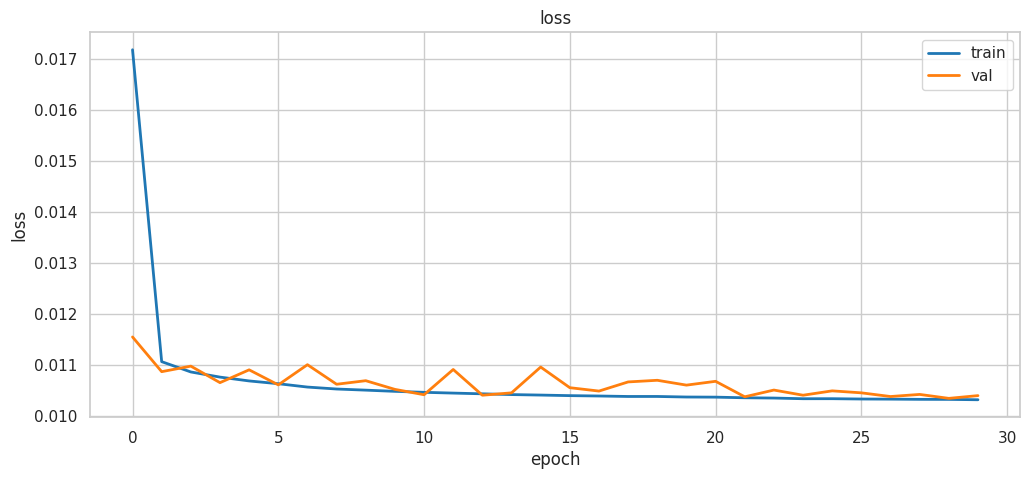

In [53]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

In [54]:
#test set
test_set_predict = test_set.drop(columns=['percentage_docks_available'], axis=1)


test_set_predict_categorical = test_set_predict[cat_columns].values
test_set_predict_numerical = test_set_predict.drop(columns=cat_columns, axis=1).values

input_list_test = [test_set_predict_categorical, test_set_predict_numerical]

y_test = test_set['percentage_docks_available'].copy().values

In [55]:
# Make prediction
y_test_predict = model.predict(input_list_test)

ValueError: ignored

In [ ]:
y_test_predict = y_test_predict.flatten()

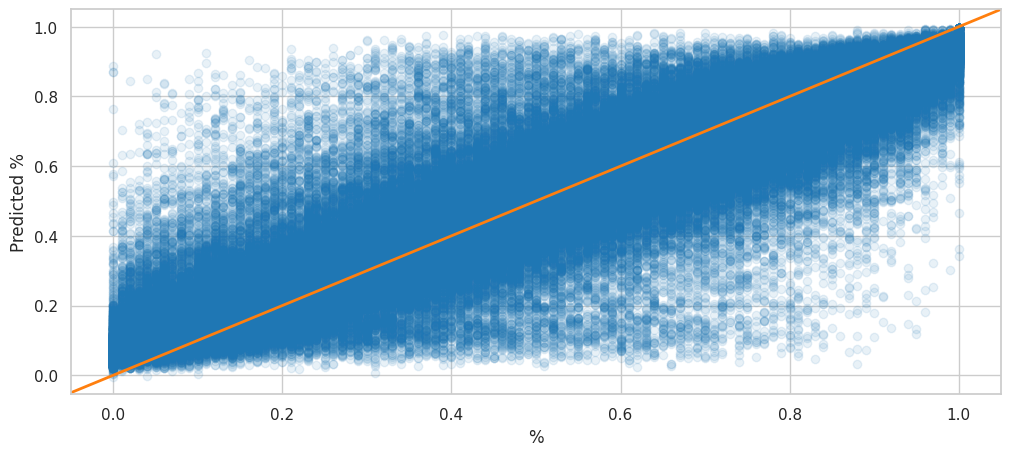

In [ ]:
plt.scatter(y_test, y_test_predict, c='C0', alpha=0.1)
plt.axline((0,0),(1,1), c='C1')
plt.xlabel('%')
plt.ylabel('Predicted %');
plt.show()

In [ ]:
# Mean squared error
MSE = mean_squared_error(y_test, y_test_predict)
# Root mean squared error
RMSE = np.sqrt(MSE)
# Mean absolute error
MAE = mean_absolute_error(y_test, y_test_predict)

R2 = r2_score(y_test, y_test_predict)
MAPE = mean_absolute_percentage_error(y_test, y_test_predict)

print(f'The MSE for the model is {MSE:.4f}')
print(f'The RMSE for the model is {RMSE:.4f}.')
print(f'The MAE for the model is {MAE:.4f}.')
print(f'The R-squared for the model is {R2:.4f}.')
#print(f'The MAPE for the model is {MAPE:.4f}.')

The MSE for the model is 0.0090
The RMSE for the model is 0.0948.
The MAE for the model is 0.0555.
The R-squared for the model is 0.8964.


___
## Data from Kaggle:
To predict the test set and generate the submission file

In [ ]:
kaggle_set = pd.read_csv('/content/drive/My Drive/CapstoneProject_NathyDani/kaggle_set.csv')
kaggle_set

,station_id,month,day,hour,ctx-4,ctx-3,ctx-2,ctx-1,lat,lon,altitude,year,day_of_week,temp,prec,wind
0,394,3,7,8,0.753086,0.780864,0.799383,0.824074,41.387306,2.163126,25.0,2023,1,11.4,0.0,6.4
1,337,3,23,12,0.463768,0.536232,0.532609,0.601449,41.398624,2.120494,117.0,2023,3,14.8,0.0,5.0
2,368,3,31,1,0.787037,0.709877,0.611111,0.601852,41.396839,2.175660,21.0,2023,4,19.0,0.0,5.8
3,327,3,23,15,0.753472,0.809028,0.819444,0.736111,41.405007,2.134603,114.0,2023,3,14.8,0.0,5.0
4,328,3,4,20,0.861111,0.802469,0.814815,0.827160,41.402988,2.134469,106.0,2023,5,9.1,0.0,6.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54994,269,3,14,3,0.478261,0.478261,0.478261,0.478261,41.448152,2.192940,26.0,2023,1,16.9,0.0,6.9
54995,280,3,1,5,0.098765,0.074074,0.074074,0.077160,41.413866,2.177727,49.0,2023,2,6.1,0.0,5.3
54996,180,3,20,16,0.782680,0.821895,0.812092,0.777778,41.367557,2.138822,14.0,2023,0,12.6,0.0,3.3
54997,277,3,14,11,0.774691,0.953704,0.972222,0.472222,41.408211,2.168996,60.0,2023,1,16.9,0.0,6.9


In [ ]:
kaggle_set_labels = pd.merge(kaggle_set, labels, on='station_id', how='left')

In [ ]:
kaggle_set_labels.head()

,station_id,month,day,hour,ctx-4,ctx-3,ctx-2,ctx-1,lat,lon,altitude,year,day_of_week,temp,prec,wind,label
0,394,3,7,8,0.753086,0.780864,0.799383,0.824074,41.387306,2.163126,25.0,2023,1,11.4,0.0,6.4,2.0
1,337,3,23,12,0.463768,0.536232,0.532609,0.601449,41.398624,2.120494,117.0,2023,3,14.8,0.0,5.0,1.0
2,368,3,31,1,0.787037,0.709877,0.611111,0.601852,41.396839,2.175660,21.0,2023,4,19.0,0.0,5.8,4.0
3,327,3,23,15,0.753472,0.809028,0.819444,0.736111,41.405007,2.134603,114.0,2023,3,14.8,0.0,5.0,1.0
4,328,3,4,20,0.861111,0.802469,0.814815,0.827160,41.402988,2.134469,106.0,2023,5,9.1,0.0,6.1,1.0


In [ ]:
kaggle_set_labels['label'].unique()

array([ 2.,  1.,  4.,  3.,  0., nan])

In [ ]:
kaggle_set_labels[kaggle_set_labels['label'].isna()]['station_id'].unique()

array([143])

In [ ]:
#we check the map and the cluster model to manually complete the label for this station
kaggle_set_labels.loc[kaggle_set_labels['station_id']==143, ['label']] = 2.0

In [ ]:
kaggle_set_labels['label'] = kaggle_set_labels['label'].astype(int)

In [ ]:
# Label -> rain==1, no rain ==0
#kaggle_set.loc[(kaggle_set['prec'] > 0)] = 1

In [ ]:
#kaggle_set['prec'].unique()

array([0., 1.])

In [ ]:
#get categorical column values
kaggle_cat = kaggle_set[cat_columns].values

In [ ]:
#gets numerical columns values
kaggle_num = kaggle_set[num_column].values

In [ ]:
kaggle_input = [kaggle_cat, kaggle_num ]

In [ ]:
final_predictions = model.predict(kaggle_input)

1719/1719 [==============================] - 3s 2ms/step


In [ ]:
df_output = pd.DataFrame(final_predictions)
df_output = df_output.reset_index()
df_output.columns = ['index','percentage_docks_available']
df_output

,index,percentage_docks_available
0,0,0.809152
1,1,0.651178
2,2,0.593225
3,3,0.732983
4,4,0.821908
...,...,...
54994,54994,0.490502
54995,54995,0.139463
54996,54996,0.752673
54997,54997,0.494671


In [ ]:
path = '/content/drive/My Drive/CapstoneProject_NathyDani/embedding_test13_NathaliayDaniela_270622.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  df_output.to_csv(f, index=False)